In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
import pandas as pd
import math as maths
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
from scipy.integrate import odeint
from scipy.optimize import minimize as minimise, curve_fit
from scipy.stats import ttest_rel as ttest

sns.set(style="white", color_codes=True) #, rc= {'figure.facecolor':'palegreen', 'axes.facecolor':'honeydew'}
sns.despine(trim = True)
sns.set_context('poster', font_scale = 1)
sns.set_palette("colorblind") #sns colormap for graph

# Fitting 8-parameter model to data

After testing 8- parameter model fit and sensitivity, it is applied to experimental count data for iCYCD3;1, Col-0, iSPCH and iMUTE plants.

Changes in parameter values between the mock and estradiol treated plants are analysed.

In [5]:
int_params = np.zeros(8) #initial parameter values for fitting algorithm
timespan = np.linspace(0,72,100) #timespan of the model (0 - 72 hours, with 1000 timepoints)
timepoints = [0, 24, 48, 72] #actual timepoints in hours of the data
sigma = [100, 0.00001, 0.00001, 0.00001] #weighting to ensure fitting includes 
                                        #first data point for more accurate fitting

In [6]:
def diffeq(y, t, k0, k1,k2, k3, k4, k5, k6,k7):
    
    '''Function containing the ODEs for the model system
    inputs:
    y - array of initial cell numbers in form [mc, gmc, stm, slgc, pc]
    t - time over which the function runs (not necessary for the equation, 
    but is for integration with odeint)
    k0, k1, k2, k3, k4, k5, k6 - float, parameter values'''
    
    #initial cell numbers
    MCi = y[0]
    GMCi = y[1]
    STMi = y[2]
    SLGCi = y[3]
    PCi = y[4]
    #the model equations =
    f0 = (k5*SLGCi)-((k0+k2)*MCi)+(k7*GMCi)
    f1 = (k0*MCi)-((k1+k7)*GMCi)
    f2 = (k1*GMCi)
    f3 = ((k2*MCi)-((k5+k3)*SLGCi)+ k6*PCi)
    f4 = (k3*SLGCi) + ((k4-k6)*PCi) 
    
    return [f0, f1, f2, f3, f4]




In [7]:
def diffeqsolver(y1, t1, parameters1):

    '''
    function which passes the input from func to odeint
    inputs:
        y1 - array of initial cell numbers in form [mc, gmc, stm, slgc, pc]
        t1 - time for diffeq solver
        parameters - list of parameters to be fed to diffeqs
    '''

    parameters_tuple = tuple(parameters1)

    soln = odeint(diffeq, y1, t1, args = parameters_tuple)
    MC = soln[:, 0]
    GMC = soln[:, 1]
    STM = soln[:, 2]
    SLGC = soln[:, 3]
    PC = soln[:, 4]

    return [MC, GMC, STM, SLGC, PC]

In [16]:
def param_fitter(cell_counts, initial_guess):
    '''
    function to pass data through scipy.minimize (here named minimise)
    input:
        - cell counts at t0
        - initial guess of parameter values
        
    output:
        - scipy.minimise object attribute .x, which is the minimised parameter values.
    '''
    initial_guess = initial_guess
    def minimiser(params1):

        '''function to be minimised by the scipy minimiser.
        accepts only params, an array of the first guesses for each parameter.

        outputs the regression for the fit between a line of best fit and the model.'''

        xlist = cell_counts #cell type to be fitted to
        y1 = xlist[:,0]

        y = diffeqsolver(y1, timespan, params1)
        minval = np.zeros(len(xlist))  
        for x in range(len(xlist)):
            
            curve = np.polyfit([0, 24, 48, 72],xlist[x], 1)#, w = sigma) #fit cell counts from data to a curve for linregress

            x2 = np.polyval(curve, timespan) #evaluate curve over timecourse

            y0 = y[x] #values from integrated ode over time

            ss=lambda data,model:((data-model)**2).sum()
            minval[x] = ss(x2, y0)
            
        return minval.sum()
    
    solution = minimise(minimiser, initial_guess, bounds = 
                        ((0, None),(0, None),(0, None),
                         (0, None),(0, None),(0, None),(0, None),(0,None)))
    

    return solution.x


# Data Wrangling

In [9]:
file_name = 'cell_population_counts_Col0_Mute_SPCH.xlsx'
dfAllCounts = pd.read_excel(open(file_name,'rb'), sheetname='test counts') #make df from spreadsheet

cond_dict = {}
conditions_dict = {}  

conditions_list = list(itertools.product(dfAllCounts.background.unique(), 
                                    dfAllCounts.growth_condition.unique(),
                                    dfAllCounts.time.unique())) 

for b,i,t in conditions_list:
    '''
    sorts dataframe into dictionary, cond_dict, where:
    cond_dict[genotype, treatment, timepoint] = [SPCs, Stomata, SLGCs, PCs]
    '''
    
    conditionPD = dfAllCounts[(dfAllCounts.background == b)&(dfAllCounts.time == t)
                                           &(dfAllCounts.growth_condition == i)]
    
    avgarea = np.nanmean(conditionPD.avg_cell_area.values)

    
    cond_dict[b,i,t]=np.asarray([
       (np.nanmean(conditionPD.MC.values)*avgarea),
        (np.nanmean(conditionPD.GMC.values)* avgarea),
       (np.nanmean(conditionPD.Stomata.values)* avgarea),
        (np.nanmean(conditionPD.SLGC.values)* avgarea),
        (np.nanmean(conditionPD.PC.values)* avgarea)])

for b,i in list(itertools.product(dfAllCounts.background.unique(), 
                                    dfAllCounts.growth_condition.unique())):
    '''
    sorts dataframe into dictionary, conditions_dict, where:
    cond_dict[genotype, treatment] = [[SPCs at t0,..., SPCs at tn],
                          [Stomata at t0,..., Stomata at tn],
                          [SLGCs at t0,..., SLGCs at tn],
                          [PCs at t0,..., PCs at tn]]
    for feeding into scipy.odeint.
    '''
    
    
    MCS = [cond_dict[b, i, t][0] for t in dfAllCounts.time.unique()]
    GMCS = [cond_dict[b, i, t][1] for t in dfAllCounts.time.unique()]
    STMS = [cond_dict[b, i, t][2] for t in dfAllCounts.time.unique()]
    SLGCS = [cond_dict[b, i, t][3] for t in dfAllCounts.time.unique()]
    PCS = [cond_dict[b, i, t][4] for t in dfAllCounts.time.unique()]
    
    conditions_dict[b,i] = [MCS, GMCS, STMS, SLGCS, PCS]
    
cell_counts = np.asarray(conditions_dict['Col0', 'mock'])
cell_counts[:, 1]

array([ 0.05364771,  0.0465888 ,  0.19341411,  0.6296547 ,  0.09600116])

# Parameter Fitting

In [10]:
'''
iterate over all the conditions in the dataframe, extract the count values at each timepoint and fit the parameters of diffeq to 
the line of best fit to those values over time.

generates a dictionary:
    -param_dict[background, condition] =  [fitted parameter values]
'''
param_dict = {}

for b,i in list(itertools.product(dfAllCounts.background.unique(), 
                                                  dfAllCounts.growth_condition.unique())):
    #int_params = np.random.random((1,8))
    parameter_values = int_params #int_params defined at top
    cell_list = np.asarray(conditions_dict[b, i])

    fitted_params = param_fitter(cell_list, parameter_values)
    param_dict[b,i] = fitted_params

paramDf = pd.DataFrame.from_dict(param_dict)

paramDf

CYCD3;1                Col0                MUTE                SPCH  \
        est      mock       est      mock       est      mock       est   
0  0.044381  0.031150  0.004456  0.005106  0.019857  0.017876  1.986293   
1  0.038811  0.031634  0.015005  0.015789  0.032726  0.030687  0.027920   
2  0.000000  0.000000  0.008764  0.005026  0.000000  0.000000  0.040054   
3  0.000000  0.000000  0.000005  0.000020  0.000000  0.011515  1.040369   
4  0.007397  0.002430  0.000000  0.000000  0.010458  0.007976  0.008158   
5  0.000928  0.000898  0.000000  0.000000  0.000054  0.000432  0.003296   
6  0.010737  0.005832  0.000000  0.004053  0.015943  0.113237  5.742268   
7  0.000000  0.000000  0.000000  0.000037  0.000000  0.000000  1.221303   

             
       mock  
0  0.044975  
1  0.037376  
2  0.000000  
3  0.001001  
4  0.001521  
5  0.001527  
6  0.010861  
7  0.009211

# Ttests of data

In [11]:
ttest_dict = {}

for b in list(dfAllCounts.background.unique()):

    cell_list = np.asarray(conditions_dict[b, 'mock'])
    cell_list_2 = np.asarray(conditions_dict[b, 'est'])
    tval = ttest(cell_list, cell_list_2)
    ttest_dict[b] = tval[1]

ttestDf = pd.DataFrame.from_dict(ttest_dict)
ttestDf

,CYCD3;1,Col0,MUTE,SPCH
0,0.516793,NaN,NaN,NaN
1,0.654318,0.797566,0.348326,0.580685
2,0.698788,0.986568,0.390107,0.745039
3,0.837649,0.854785,0.356303,0.356165


# Calculate change in parameters and plot

- outputs table of changes in parameter values between est and mock treated plants, and graph showing log change * sign of change to indicate direction of change.

,CYCD3;1,Col0,MUTE,SPCH
,diff,diff,diff,diff
0,42.474322,-12.729045,11.079479,4316.416194
1,22.686386,-4.966593,6.642060,-25.300581
2,0.000000,74.392667,0.000000,4.005407
3,0.000000,-73.351427,-100.000000,103880.764793
4,204.423998,0.000000,31.118155,436.217736
5,3.237936,0.000000,-87.551639,115.884526
6,84.110794,-100.000000,-85.920622,52770.149053
7,0.000000,-100.000000,0.000000,13158.681914


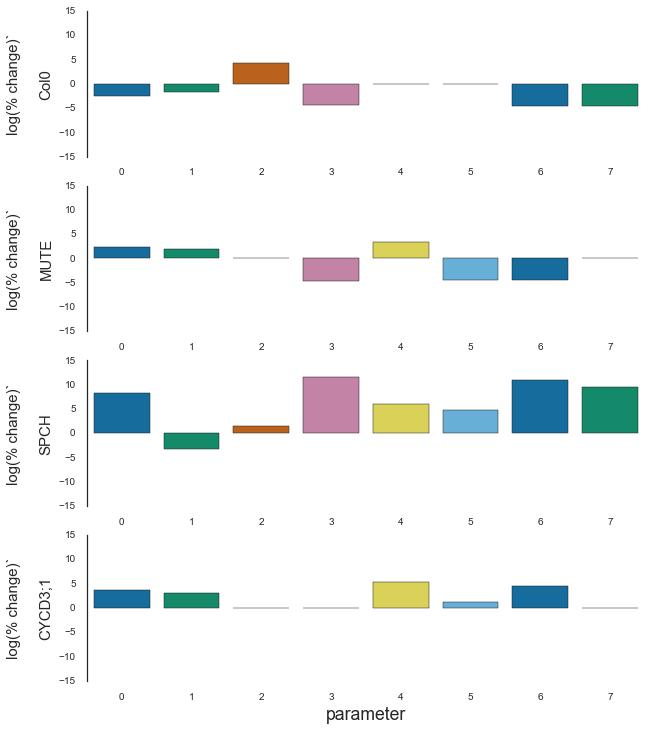

In [8]:
param_df = pd.DataFrame.from_dict(param_dict)
condition_list = np.zeros((3, 8))
j = 0
x = [0, 1, 2, 3, 4, 5, 6, 7]

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))
axes = (ax1, ax2, ax3, ax4)
axval = 0
change_dict = {}
for condition in dfAllCounts.background.unique():
    mock = pd.DataFrame.as_matrix(param_df[condition, 'mock'])
    est = pd.DataFrame.as_matrix(param_df[condition, 'est'])
    percent_val = [est[i]*100 if mock[i] == 0 else ((est[i]-mock[i])/mock[i])*100 for i in range(len(est))]
    log_val =  [0 if x==0 else np.sign(x)*maths.fabs(maths.log(maths.fabs(x))) for x in percent_val]
    sns.barplot(x, log_val, ax = axes[axval], palette='colorblind')

    axes[axval].tick_params(labelsize= 10)
    axes[axval].set_ylim(-15,15)
    
    change_dict[condition, 'diff'] = percent_val
    axes[axval].set_ylabel('log(% change)'+'`\n \n'+condition, fontsize = 15)  
    axval += 1
    
sns.despine(bottom=True)
#plt.tight_layout(h_pad=1)
plt.xlabel('parameter')
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('percent_difference.svg')
plt.subplots_adjust(wspace = 0.5, hspace = 0.2)
change_pd = pd.DataFrame.from_dict(change_dict)
change_pd

# Run simulations using fitted parameters

In [12]:
'''
make graph showing simulation results with data and LOBF for comparison.

graphs with 3 subplots:
- simulated data with fitted parameters from the algorithm above
- line of best fit of actual data
- actual data

'''

soln_dict = {}

for b,i in list(itertools.product(dfAllCounts.background.unique(), 
                                  dfAllCounts.growth_condition.unique())):
    
    ''' simulate data using fitted parameters '''
    
    count_list = np.asarray(conditions_dict[b, i])
    initial_counts = count_list[:, 0]
    sim_params = param_dict[b,i]

    soln = odeint(diffeq, initial_counts, timespan, args = tuple(sim_params))
    
    MC = soln[:, 0]
    GMC = soln[:, 1]
    STM = soln[:, 2]
    SLGC = soln[:, 3]
    PC = soln[:, 4]
    solutions = [MC, GMC, STM, SLGC, PC]  
    soln_dict[b,i] = solutions
    


## Generate graphs showing simulated data next to line of best fit of actual data

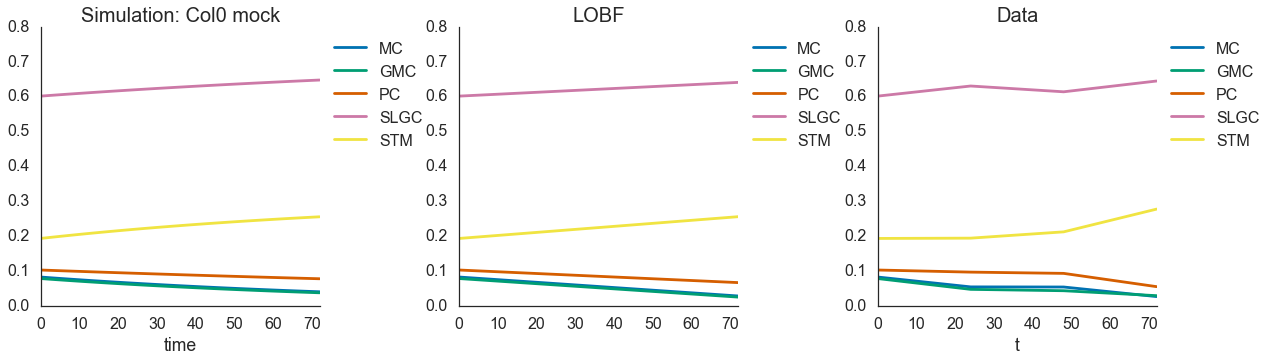

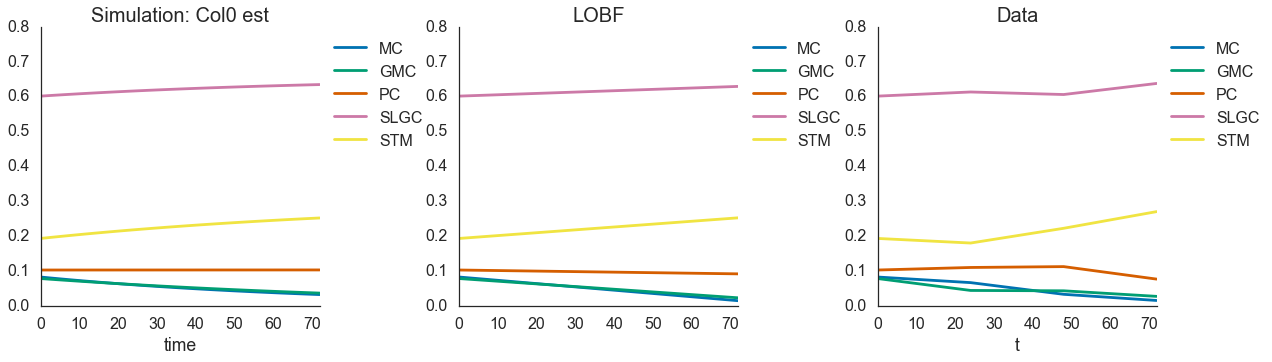

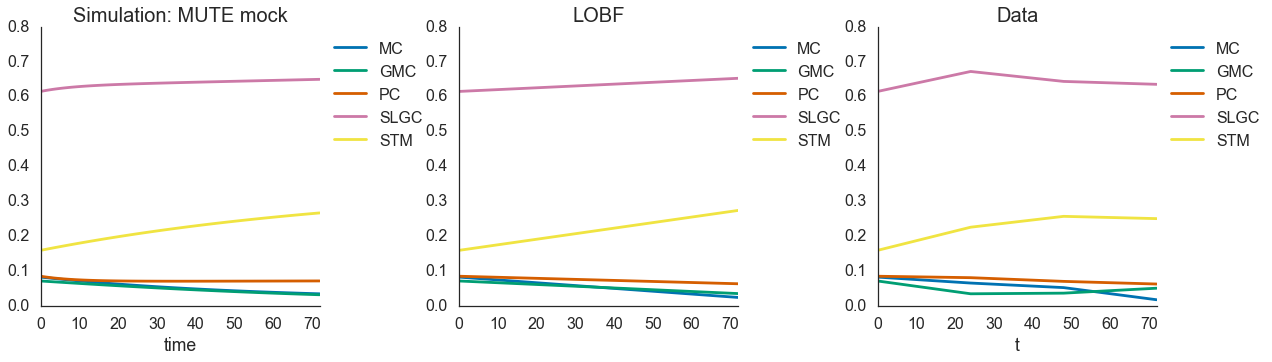

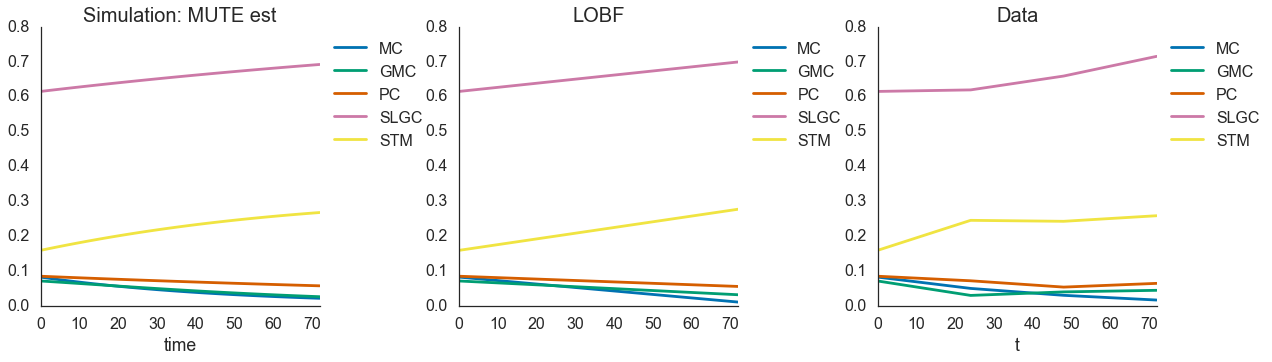

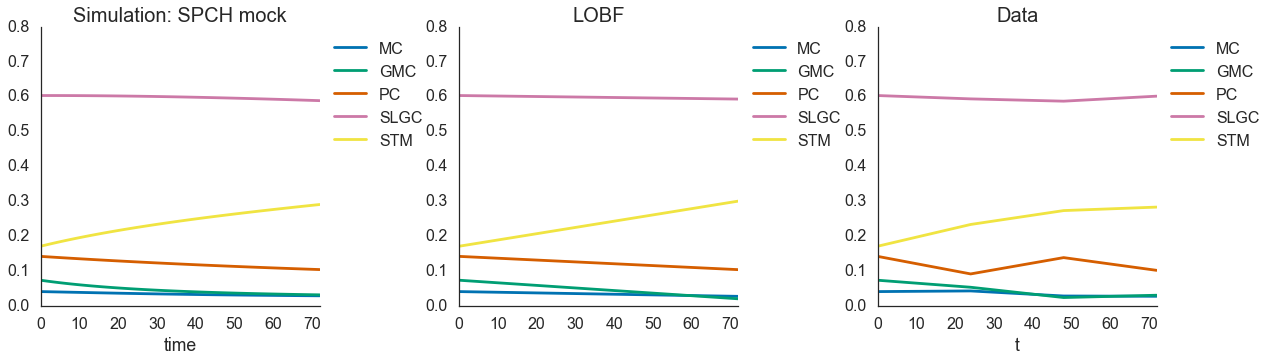

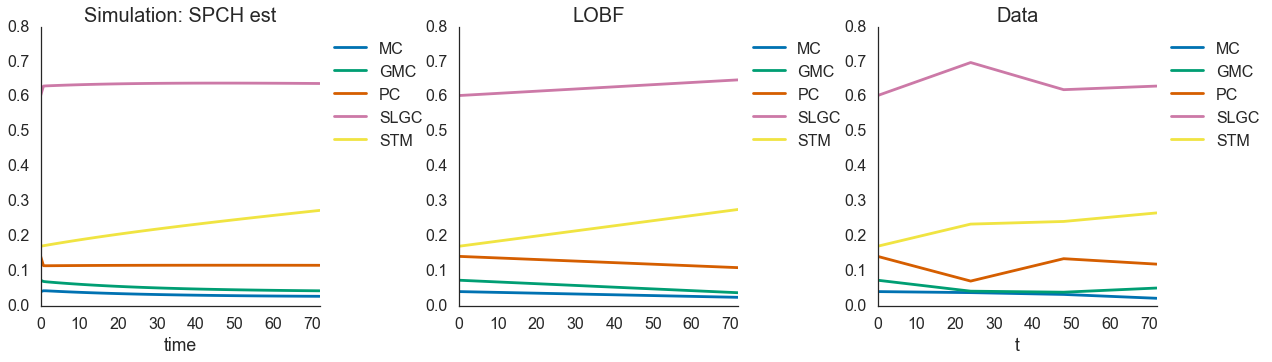

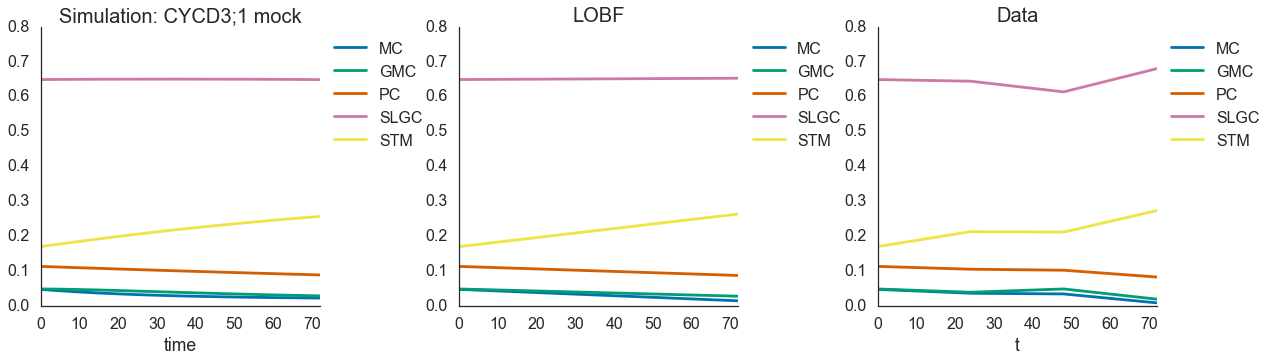

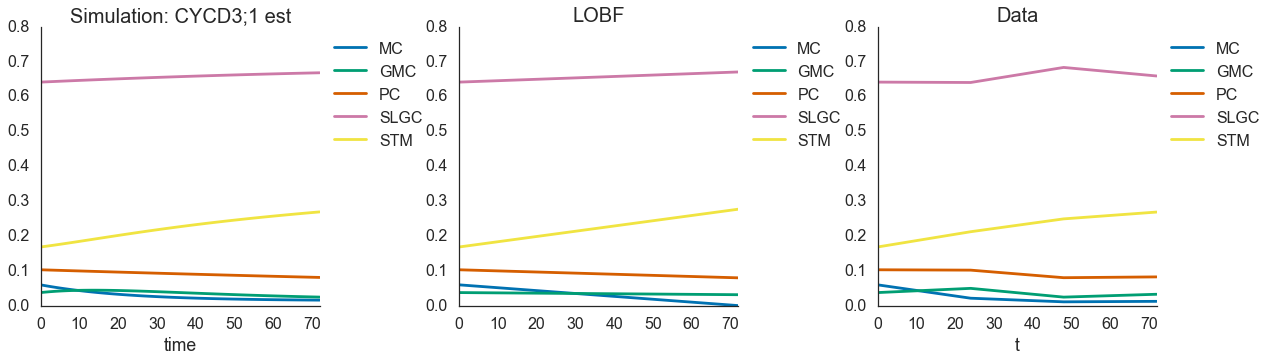

In [15]:
for b,i in list(itertools.product(dfAllCounts.background.unique(), 
                                  dfAllCounts.growth_condition.unique())):
    fig = plt.figure(figsize=(20,5))
    cell_counts = np.asarray(conditions_dict[b, i])
    
    
    axs = fig.add_subplot(1, 3, 1)
    MC, GMC, STM, SLGC, PC = soln_dict[b,i]
    resultsDf = pd.DataFrame({'time': timespan, 'MC' : MC, 'GMC' : GMC, 'PC' : PC, 'SLGC' : SLGC,'STM':STM})
    resultsDf.plot(x = 'time', y = ['MC','GMC','PC','SLGC','STM'], ax = axs)
    
    axs.set_title('Simulation: '+b+' '+i, fontsize = 20)
    axs.set_ylim(0, 0.8)
    
    '''actual data from excel spreadsheet '''
    axs1 = fig.add_subplot(1, 3, 3)
    dataDf = pd.DataFrame({'time': timepoints, 
                              'MC' : cell_counts[0, :], 
                              'GMC' : cell_counts[1, :],
                              'STM' : cell_counts[2, :],
                              'SLGC' : cell_counts[3, :],
                              'PC': cell_counts[4, :]})

    dataDf.plot(x = 'time', y = ['MC', 'GMC', 'PC', 'SLGC', 'STM'],ax=axs1)
    axs1.set_xlabel('t')
    axs1.set_ylabel('')
    axs1.set_ylim(0, 0.8)
    axs1.set_title('Data', fontsize = 20)

    ''' lobf for data'''
    axs2 = fig.add_subplot(1, 3, 2)
    namelist = ['MC', 'GMC','STM','SLGC','PC']
    time = [0, 24, 48, 72]  
    curve_dict = {}
    for n in range(len(cell_counts[:,0])):

        curve = np.polyfit(time ,cell_counts[n], 1, w=sigma)
        x2 = np.polyval(curve, timespan)
        curve_dict[namelist[n]] = x2
    fit_df = pd.DataFrame.from_dict(curve_dict)
    fit_df.plot(x = timespan, y = ['MC', 'GMC', 'PC', 'SLGC', 'STM'],ax=axs2)
    axs2.set_title('LOBF', fontsize = 20)
    axs2.set_ylim(0, 0.8)
    axs.legend(bbox_to_anchor=(1, 1), loc=2)
    axs1.legend(bbox_to_anchor=(1, 1), loc=2)
    axs2.legend(bbox_to_anchor=(1, 1), loc=2)
    plt.subplots_adjust(wspace = 0.5, hspace = 0.2)
    sns.despine()
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig('k8_parameter_fitting'+b+i+'.svg')